Loading test data...
Preparing test data...
Loading model...
Running test evaluation...

Test Set Results:
Average Loss: 3.3023
Accuracy: 5.77%
Correct Predictions: 577/10000

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        46
           5       0.00      0.00      0.00        63
           6       0.00      0.00      0.00        92
           7       0.00      0.00      0.00       141
           8       0.00      0.00      0.00       167
           9       0.00      0.00      0.00       221
          10       0.05      0.04      0.04       279
          11       0.00      0.00      0.00       381
          12       0.00      0.00      0.00       426
          13       0.07      0.01  

c:\Users\Kapil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kapil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kapil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


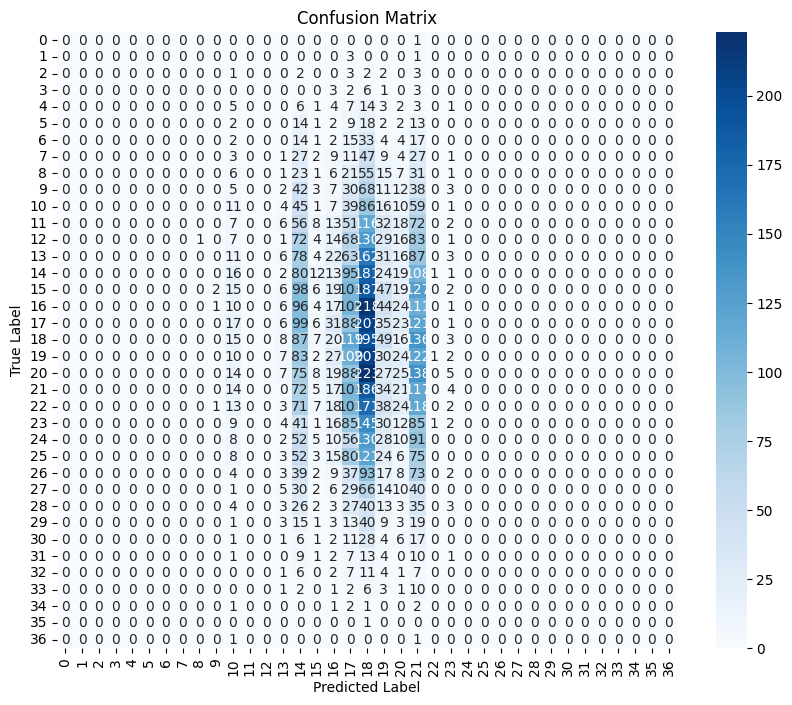


Test results saved to 'test_results.npy'


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_predictions = []
    all_labels = []
    test_loss = 0
    correct = 0
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    print("\nTest Set Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Correct Predictions: {correct}/{total}")
    
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_predictions))
    
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'predictions': all_predictions,
        'true_labels': all_labels
    }

def prepare_test_data(test_data, test_labels):
    processed_images = []
    
    for img in test_data:
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (28, 28))
        img = img.astype(np.float32) / 255.0
        processed_images.append(img)
    
    processed_images = np.array(processed_images)
    test_images = torch.tensor(processed_images, dtype=torch.float32).unsqueeze(1)
    test_labels = torch.tensor(test_labels, dtype=torch.long)
    
    return test_images, test_labels

print("Loading test data...")
test_data = np.load('DL-Project/data0.npy')
test_labels = np.load('DL-Project/lab0.npy')

print("Preparing test data...")
test_images, test_labels = prepare_test_data(test_data, test_labels)
unique_classes = len(torch.unique(test_labels))

test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Loading model...")
checkpoint = torch.load('best_model.pth')
model = CNNModel(50)
if isinstance(checkpoint, dict):
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)

print("Running test evaluation...")
test_results = test(model, test_loader)

results = {
    'test_loss': test_results['loss'],
    'test_accuracy': test_results['accuracy'],
    'predictions': test_results['predictions'],
    'true_labels': test_results['true_labels']
}

np.save('test_results.npy', results)
print("\nTest results saved to 'test_results.npy'")